In [1]:
#install python (and check the add to path option during installation), then install the ema_workbench python module.
#this can be done by executing the following command in the command prompt:
# pip install ema_workbench

#import necessary python libraries for the analysis
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

#import EMA workbench tools
from ema_workbench.em_framework import samplers, evaluators, util
from ema_workbench import (RealParameter, ScalarOutcome, Model, Constant)
from ema_workbench import (perform_experiments, ema_logging, save_results, 
                           load_results, SequentialEvaluator)
ema_logging.log_to_stderr(ema_logging.INFO)


#import PRIM algorithm
from ema_workbench.analysis import prim

C:\Users\frac1\anaconda3\lib\site-packages\ema_workbench\em_framework\evaluators.py:21: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn(
C:\Users\frac1\anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Users\frac1\anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


# 1. Load the data for the global and local analysis

In [26]:
raw_data = pd.read_csv("Data/Costs and benefits of photovoltaic-green roofs.csv")
raw_data

,Technology,Green roof type,Plant species,Irrigation,PV panel type,PV panels and GR locations,Distance PV-green roof [cm],Distance PV-basecase roof [cm],Season,Base case roof situation,...,Authors,Year,Title,Study type,"WTP Correction factor [GDPpc,EU27-year/GDPpc,country-year)",Unusable monetary value,Case-study ID,Old inflaction correction,Old PPP exchange,Old adjusted value
0,Green roof,Extensive,NaN,not mentioned,NaN,NaN,NaN,NaN,annual average,To be constructed,...,"Nordman et al,",2018.0,Benefit-cost analysis of stormwater green infr...,Cost-Benefit Analysis,NaN,NaN,Nordman - Grand Rapids,2.181461,0.719,50.975285
1,Green roof,Extensive,NaN,not mentioned,NaN,NaN,NaN,NaN,annual average,Already constructed,...,"Bianchini & Hewage,",2012.0,Probabilistic social cost-benefit analysis for...,Cost-Benefit Analysis,NaN,NaN,NaN,1.308722,0.739,2.514579
2,Green roof,Extensive,NaN,not mentioned,NaN,NaN,NaN,NaN,annual average,Already constructed,...,"Bianchini & Hewage,",2012.0,Probabilistic social cost-benefit analysis for...,Cost-Benefit Analysis,NaN,NaN,NaN,1.308722,0.739,2.514579
3,Green roof,Extensive,NaN,not mentioned,NaN,NaN,NaN,NaN,annual average,Already constructed,...,"Bianchini & Hewage,",2012.0,Probabilistic social cost-benefit analysis for...,Cost-Benefit Analysis,NaN,NaN,NaN,1.308722,0.739,8.027308
4,Green roof,Extensive,NaN,not mentioned,NaN,NaN,NaN,NaN,annual average,Already constructed,...,"Bianchini & Hewage,",2012.0,Probabilistic social cost-benefit analysis for...,Cost-Benefit Analysis,NaN,NaN,NaN,1.308722,0.739,8.027308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,Photovoltaic panels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,annual average,NaN,...,Authors' calculations (PV costs - review.csv),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
979,Photovoltaic panels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,annual average,NaN,...,Authors' calculations (PV costs - review.csv),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
980,Photovoltaic panels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,annual average,NaN,...,Authors' calculations (PV costs - review.csv),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
981,Photovoltaic panels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,annual average,NaN,...,Authors' calculations (PV costs - review.csv),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
raw_data.columns

Index(['Technology', 'Green roof type', 'Plant species', 'Irrigation',
       'PV panel type', 'PV panels and GR locations',
       'Distance PV-green roof [cm]', 'Distance PV-basecase roof [cm]',
       'Season', 'Base case roof situation', 'Building type', 'Base case roof',
       'Base case insulation', 'Roof slope', 'Item', 'Item type', 'Item scale',
       'Item class', 'Original monetary value', 'u.m.',
       'Original year(s) at which the item is accounted',
       'Green roof lifetime [years]',
       'Actual year(s) at which the item is accounted',
       'Actual monetary value at the accounting year',
       'Inflation adjustment ratio [GDP deflator 2020/GDP deflator year]',
       'PPP Exchange rate [€ EU27-2020/ local currency-2020]',
       'Adjusted Monetary value [EU27 2020 €/m2]', 'Method for monetary value',
       'Quantiative absolute evaluation', 'u.m.3',
       'Method for absolute evaluation', 'Quantiative absolute evaluation 2',
       'u.m. 3', 'Method for abso

In [28]:
raw_data.Item.unique()

array(['Aesthetics increase', 'Air pollution from green roof production',
       'Air quality enhancement',
       'Air quality enhancement and CO2 reduction',
       'Biodiversity enhancement', 'CO2 emission reduction',
       'CO2 emissions from green roof production', 'CO2 uptake',
       'Comfort increase', 'Disposal of green roof',
       'Electricity generation', 'Energy consumption reduction',
       'Energy consumption reduction (all appliances)',
       'Energy consumption reduction (cooling)',
       'Energy consumption reduction (heating and cooling)',
       'Energy consumption reduction (heating)', 'Feasibility inspection',
       'Fire risk reduction', 'Flood risk reduction',
       'Groundwater recharging', 'Incentive',
       'Installation of green roof (gross)',
       'Installation of green roof (net)',
       'Installation of green roof without feasibility inspection (gross)',
       'Installation of PV panels', 'Installation of white roof',
       'Job creation', "L

In [29]:
# Selection of global analysis' data

# Only aggregated versions of benefits (e.g., energy consumption total, instead of energy consumption cooling only) are kept
# and differential values with respect of the construction of the alternative basecase roof (i.e., net values) are kept. 
# This choice is due to the fact that net values are more numerous than gross values.

global_items = raw_data[((raw_data["Technology"] == "Green roof") | 
                         (raw_data["Technology"] == "Photovoltaic-green roof") ) &
                        (raw_data["Unusable monetary value"] != "x") &
                        ((raw_data["Item"] == "Urban heat island effect mitigation") |
                        (raw_data["Item"] == "Water runoff quality increase") |
                        (raw_data["Item"] == "Urban noise reduction") |
                        (raw_data["Item"] == "Biodiversity enhancement") |
                        (raw_data["Item"] == "Energy consumption reduction (heating and cooling)") |
                        (raw_data["Item"] == "Sound insulation") |
                        (raw_data["Item"] == "Aesthetics increase") |
                        (raw_data["Item"] == "Replacement and disposal of green roof") |
                        (raw_data["Item"] == "Installation of green roof (net)") |
                        (raw_data["Item"] == "Longevity increase") |
                        (raw_data["Item"] == "Fire risk reduction") |
                        (raw_data["Item"] == "Maintenance of green roof (net)") |
                        (raw_data["Item"] == "Air quality enhancement") |
                        (raw_data["Item"] == "CO2 emission reduction") |
                        (raw_data["Item"] == "Stormwater management") |
                        (raw_data["Item"] == "Air pollution from green roof production") |
                        (raw_data["Item"] == "CO2 emissions from green roof production") |
                        (raw_data["Item"] == "CO2 uptake") |
                        (raw_data["Item"] == "Electricity generation") |
                        (raw_data["Item"] == "Water runoff quality increase") |
                        (raw_data["Item"] == "Local area's aesthetics increase") |
                        (raw_data["Item"] == "Installation of PV panels"))]

global_items = global_items[["Item","Item type", "Actual year(s) at which the item is accounted", "Adjusted Monetary value [EU27 2020 €/m2]"]]

global_costs = global_items[ (global_items["Item type"]=="cost") ]
global_benefits = global_items[ (global_items["Item type"]=="benefit") ]
display(global_costs)
display(global_benefits)

,Item,Item type,Actual year(s) at which the item is accounted,Adjusted Monetary value [EU27 2020 €/m2]
39,Air pollution from green roof production,cost,0,2.117852
40,Air pollution from green roof production,cost,0,2.117852
41,Air pollution from green roof production,cost,0,9.339926
42,Air pollution from green roof production,cost,0,9.339926
43,Air pollution from green roof production,cost,0,14.744790
...,...,...,...,...
636,Replacement and disposal of green roof,cost,last year,30.141763
637,Replacement and disposal of green roof,cost,last year,40.648139
638,Replacement and disposal of green roof,cost,last year,58.653542
639,Replacement and disposal of green roof,cost,last year,58.653542


,Item,Item type,Actual year(s) at which the item is accounted,Adjusted Monetary value [EU27 2020 €/m2]
0,Aesthetics increase,benefit,0,23.580849
1,Aesthetics increase,benefit,0,1.973705
2,Aesthetics increase,benefit,0,1.973705
3,Aesthetics increase,benefit,0,6.300675
4,Aesthetics increase,benefit,0,6.300675
...,...,...,...,...
809,Water runoff quality increase,benefit,every year,0.001244
810,Water runoff quality increase,benefit,every year,0.001244
811,Water runoff quality increase,benefit,every year,0.293232
812,Water runoff quality increase,benefit,every year,0.308504


In [30]:
# Selection of local analysis' data

local_items = raw_data[((raw_data["Technology"] == "Green roof") | 
                         (raw_data["Technology"] == "Photovoltaic-green roof") ) &
                        (raw_data["Base case roof"] == "black roof") &
                        (raw_data["Climate"] == "Cfb") &
                        (raw_data["Continent"] == "Europe") &
                        (raw_data["Unusable monetary value"] != "x") &
                        ((raw_data["Item"] == "Urban heat island effect mitigation") |
                        (raw_data["Item"] == "Water runoff quality increase") |
                        (raw_data["Item"] == "Urban noise reduction") |
                        (raw_data["Item"] == "Biodiversity enhancement") |
                        (raw_data["Item"] == "Energy consumption reduction (heating and cooling)") |
                        (raw_data["Item"] == "Sound insulation") |
                        (raw_data["Item"] == "Aesthetics increase") |
                        (raw_data["Item"] == "Replacement and disposal of green roof") |
                        (raw_data["Item"] == "Installation of green roof (net)") |
                        (raw_data["Item"] == "Longevity increase") |
                        (raw_data["Item"] == "Fire risk reduction") |
                        (raw_data["Item"] == "Maintenance of green roof (net)") |
                        (raw_data["Item"] == "Air quality enhancement") |
                        (raw_data["Item"] == "CO2 emission reduction") |
                        (raw_data["Item"] == "Stormwater management") |
                        (raw_data["Item"] == "Air pollution from green roof production") |
                        (raw_data["Item"] == "CO2 emissions from green roof production") |
                        (raw_data["Item"] == "CO2 uptake") |
                        (raw_data["Item"] == "Electricity generation") |
                        (raw_data["Item"] == "Water runoff quality increase") |
                        (raw_data["Item"] == "Local area's aesthetics increase") |
                        (raw_data["Item"] == "Installation of PV panels"))]

local_items = local_items[["Item","Item type", "Actual year(s) at which the item is accounted", "Adjusted Monetary value [EU27 2020 €/m2]"]]

local_costs = local_items[ (local_items["Item type"]=="cost") ]
local_benefits = local_items[ (local_items["Item type"]=="benefit") ]
display(local_costs)
display(local_benefits)

,Item,Item type,Actual year(s) at which the item is accounted,Adjusted Monetary value [EU27 2020 €/m2]
404,Installation of green roof (net),cost,0,18.605990
411,Installation of green roof (net),cost,0,31.583495
412,Installation of green roof (net),cost,0,33.212560
413,Installation of green roof (net),cost,0,34.841625
421,Installation of green roof (net),cost,0,89.751634
422,Installation of green roof (net),cost,0,89.751634
425,Installation of green roof (net),cost,0,95.735077
426,Installation of green roof (net),cost,0,95.735077
435,Installation of green roof (net),cost,0,84.307442
436,Installation of green roof (net),cost,0,84.307442


,Item,Item type,Actual year(s) at which the item is accounted,Adjusted Monetary value [EU27 2020 €/m2]
32,Aesthetics increase,benefit,0,328.339910
50,Air quality enhancement,benefit,every year,0.012625
65,Air quality enhancement,benefit,every year,0.375703
67,Air quality enhancement,benefit,every year,0.499919
68,Air quality enhancement,benefit,every year,0.030853
110,Biodiversity enhancement,benefit,every year,0.154169
124,CO2 emission reduction,benefit,every year,0.020363
126,CO2 emission reduction,benefit,every year,0.030545
127,CO2 emission reduction,benefit,every year,0.082471
154,CO2 uptake,benefit,every year,0.003410


In [31]:
# Visualize the years at which the costs and benefits need to be accounted in the CBA Model

global_costs.groupby("Item")["Actual year(s) at which the item is accounted"].agg(lambda x:x.value_counts().index[0])

global_benefits.groupby("Item")["Actual year(s) at which the item is accounted"].agg(lambda x:x.value_counts().index[0])

Item
Aesthetics increase                                            0
Air quality enhancement                               every year
Biodiversity enhancement                              every year
CO2 emission reduction                                every year
CO2 uptake                                            every year
Electricity generation                                every year
Energy consumption reduction (heating and cooling)    every year
Fire risk reduction                                   every year
Local area's aesthetics increase                               0
Longevity increase                                    every year
Sound insulation                                      every year
Stormwater management                                 every year
Urban heat island effect mitigation                   every year
Urban noise reduction                                 every year
Water runoff quality increase                         every year
Name: Actual year(s)

## 1.1 Number of items for the global analysis

In [32]:
# determining the amount of datapoints within the range, so to gain insight into the representativeness of the using the range (i.e., max-min) for each 
# cost or benefit

def q1(Item):
    return Item.quantile(0.25)

def q3(Item):
    return Item.quantile(0.75)

def lower_whisker(Item):
    Item_without_outliers = Item[Item > q1(Item)-1.5*(q3(Item)-q1(Item))]
    return Item_without_outliers.min()

def upper_whisker(Item):
    Item_without_outliers = Item[Item < q3(Item)+1.5*(q3(Item)-q1(Item))]
    return Item_without_outliers.max()

def density(Item):
    if Item.max() - Item.min() == 0:
        return "one value only"
    return Item.nunique()/ ( Item.max() - Item.min() )

def spacing(Item):
    return ( Item.max() - Item.min() ) / Item.nunique()

# def n_without_outliers(Item):
#     """This function calculates the number of unique values recorded for each item (i.e., cost or benefit), which are not
#     outliers"""
#     values_to_count = []
    
#     for number in Item:
#         if ((number >= lower_whisker(Item)) & (number <= upper_whisker(Item))):
#             values_to_count.append(number)
#     #only unique values are counted, so the length of the set associated to the list, instead of the list is returned
#     return len(set(values_to_count))

def average(Item):
    return Item.mean()

# def density_without_outliers(Item):
#     return n_without_outliers(Item) / ( upper_whisker(Item) - lower_whisker(Item) )

# def spacing_without_outliers(Item):
#     return ( upper_whisker(Item) - lower_whisker(Item) ) / n_without_outliers(Item)

def n_outliers(Item):
    values_to_count = []
    for number in Item:
        if (( number < lower_whisker(Item) ) | ( number > upper_whisker(Item) )):
            values_to_count.append(number)
            
    #only unique values are counted, so the length of the set associated to the list, instead of the list is returned
    return len(set(values_to_count))


f = {'Adjusted Monetary value [EU27 2020 €/m2]': ['nunique', average, 'min', lower_whisker, 'median', upper_whisker, 'max', spacing]}
gl_summary_costs = global_costs.groupby('Item').agg(f)

# drop one level of the Multi-level data structure, so to have 2D Pandas DataFrame
gl_summary_costs.columns = gl_summary_costs.columns.droplevel()

# Replace the spaces in the row indexes' names (i.e., the benefits' names) with an underscore, and delete parentheses,
# so to be able to use the benefit names as variables in the CBA Model
gl_summary_costs.index = gl_summary_costs.index.str.replace("(", "")
gl_summary_costs.index = gl_summary_costs.index.str.replace(")", "")
gl_summary_costs.index = gl_summary_costs.index.str.replace(" net", "")
gl_summary_costs.index = gl_summary_costs.index.str.replace(" ","_")

display(gl_summary_costs)

# do it again for benefits
gl_summary_benefits = global_benefits.groupby('Item').agg(f)

gl_summary_benefits.columns = gl_summary_benefits.columns.droplevel()
gl_summary_benefits.index = gl_summary_benefits.index.str.replace("(", "")
gl_summary_benefits.index = gl_summary_benefits.index.str.replace(")", "")
gl_summary_benefits.index = gl_summary_benefits.index.str.replace(" heating and cooling", "")
gl_summary_benefits.index = gl_summary_benefits.index.str.replace(" ","_")

display(gl_summary_benefits)

C:\Users\frac1\AppData\Local\Temp/ipykernel_4872/4032808730.py:64: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  gl_summary_costs.index = gl_summary_costs.index.str.replace("(", "")
C:\Users\frac1\AppData\Local\Temp/ipykernel_4872/4032808730.py:65: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  gl_summary_costs.index = gl_summary_costs.index.str.replace(")", "")


,nunique,average,min,lower_whisker,median,upper_whisker,max,spacing
Item,,,,,,,,
Air_pollution_from_green_roof_production,6,9.690483,2.117852,2.117852,9.339926,15.689871,15.689871,2.262003
CO2_emissions_from_green_roof_production,3,8.734189,2.117852,2.117852,9.339926,14.744790,14.744790,4.208980
Installation_of_PV_panels,1,76.712723,76.712723,NaN,76.712723,NaN,76.712723,0.000000
Installation_of_green_roof,32,70.621068,18.605990,18.605990,79.600675,119.668846,119.668846,3.158214
Maintenance_of_green_roof,50,4.711720,-0.893647,-0.893647,0.794452,2.833643,146.252358,2.942920
Replacement_and_disposal_of_green_roof,7,36.755779,19.766926,19.766926,25.041423,58.653542,103.855845,12.012703


C:\Users\frac1\AppData\Local\Temp/ipykernel_4872/4032808730.py:75: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  gl_summary_benefits.index = gl_summary_benefits.index.str.replace("(", "")
C:\Users\frac1\AppData\Local\Temp/ipykernel_4872/4032808730.py:76: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  gl_summary_benefits.index = gl_summary_benefits.index.str.replace(")", "")


,nunique,average,min,lower_whisker,median,upper_whisker,max,spacing
Item,,,,,,,,
Aesthetics_increase,19,91.539244,1.973705,1.973705,75.544018,154.795077,328.339910,17.177169
Air_quality_enhancement,21,0.377763,0.012625,0.012625,0.132600,1.084652,1.481821,0.069962
Biodiversity_enhancement,9,0.280780,0.000000,0.000000,0.140782,0.671752,0.671752,0.074639
CO2_emission_reduction,16,0.411049,-0.028056,-0.028056,0.127812,0.375124,3.399472,0.214221
CO2_uptake,11,0.447714,0.000000,0.000000,0.001230,0.039526,5.687937,0.517085
Electricity_generation,18,11.522450,2.797891,2.797891,10.688906,18.846151,18.846151,0.891570
Energy_consumption_reduction,71,5.100971,-0.384476,-0.384476,0.745379,3.865544,54.027255,0.766362
Fire_risk_reduction,5,0.063330,0.000000,0.000000,0.074639,0.111959,0.111959,0.022392
Local_area's_aesthetics_increase,3,355.990747,0.000097,0.000097,250.286396,817.685748,817.685748,272.561884


## 1.2 Number of items for the local analysis

In [19]:
f = {'Adjusted Monetary value [EU27 2020 €/m2]': ['nunique', average, 'min', lower_whisker, q1, 'median', q3, upper_whisker, 'max', density, spacing]}
loc_summary_costs = local_costs.groupby('Item').agg(f)

# drop one level of the Multi-level data structure, so to have 2D Pandas DataFrame
loc_summary_costs.columns = loc_summary_costs.columns.droplevel()

# Replace the spaces in the row indexes' names (i.e., the benefits' names) with an underscore, and delete parentheses,
# so to be able to use the benefit names as variables in the CBA Model
loc_summary_costs.index = loc_summary_costs.index.str.replace("(", "")
loc_summary_costs.index = loc_summary_costs.index.str.replace(")", "")
loc_summary_costs.index = loc_summary_costs.index.str.replace(" net", "")
loc_summary_costs.index = loc_summary_costs.index.str.replace(" ","_")

display(loc_summary_costs)

# do it again for benefits
loc_summary_benefits = local_benefits.groupby('Item').agg(f)

loc_summary_benefits.columns = loc_summary_benefits.columns.droplevel()
loc_summary_benefits.index = loc_summary_benefits.index.str.replace("(", "")
loc_summary_benefits.index = loc_summary_benefits.index.str.replace(")", "")
loc_summary_benefits.index = loc_summary_benefits.index.str.replace(" heating and cooling", "")
loc_summary_benefits.index = loc_summary_benefits.index.str.replace(" ","_")

display(loc_summary_benefits)

C:\Users\frac1\AppData\Local\Temp/ipykernel_4872/1829208119.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  loc_summary_costs.index = loc_summary_costs.index.str.replace("(", "")
C:\Users\frac1\AppData\Local\Temp/ipykernel_4872/1829208119.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  loc_summary_costs.index = loc_summary_costs.index.str.replace(")", "")


,nunique,average,min,lower_whisker,q1,median,q3,upper_whisker,max,density,spacing
Item,,,,,,,,,,,
Installation_of_green_roof,10,76.411902,18.605990,18.605990,47.208079,89.751634,94.283292,119.668846,119.668846,0.098948,10.106286
Maintenance_of_green_roof,13,0.557643,0.037622,0.037622,0.300321,0.470845,1.016934,1.085364,1.085364,12.407629,0.080596


C:\Users\frac1\AppData\Local\Temp/ipykernel_4872/1829208119.py:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  loc_summary_benefits.index = loc_summary_benefits.index.str.replace("(", "")
C:\Users\frac1\AppData\Local\Temp/ipykernel_4872/1829208119.py:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  loc_summary_benefits.index = loc_summary_benefits.index.str.replace(")", "")


,nunique,average,min,lower_whisker,q1,median,q3,upper_whisker,max,density,spacing
Item,,,,,,,,,,,
Aesthetics_increase,1,328.339910,328.339910,NaN,328.339910,328.339910,328.339910,NaN,328.339910,one value only,0.000000
Air_quality_enhancement,4,0.229775,0.012625,0.012625,0.026296,0.203278,0.406757,0.499919,0.499919,8.208596,0.121824
Biodiversity_enhancement,1,0.154169,0.154169,NaN,0.154169,0.154169,0.154169,NaN,0.154169,one value only,0.000000
CO2_emission_reduction,3,0.044460,0.020363,0.020363,0.025454,0.030545,0.056508,0.082471,0.082471,48.30288,0.020703
CO2_uptake,2,0.003129,0.002848,0.002848,0.002988,0.003129,0.003269,0.003410,0.003410,3558.424246,0.000281
Energy_consumption_reduction,12,0.500710,0.078595,0.078595,0.273887,0.391402,0.481675,0.603092,2.224229,5.592753,0.178803
Fire_risk_reduction,1,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,one value only,0.000000
Longevity_increase,3,5.045230,0.889976,0.889976,2.307143,7.343010,7.343010,7.343010,7.343010,0.464898,2.151011
Sound_insulation,4,0.377932,0.277959,0.277959,0.288650,0.299341,0.388623,0.306468,0.635087,11.20047,0.089282


# 2. Visualization of Costs

TypeError: boxplot() got an unexpected keyword argument 'manage_xticks'

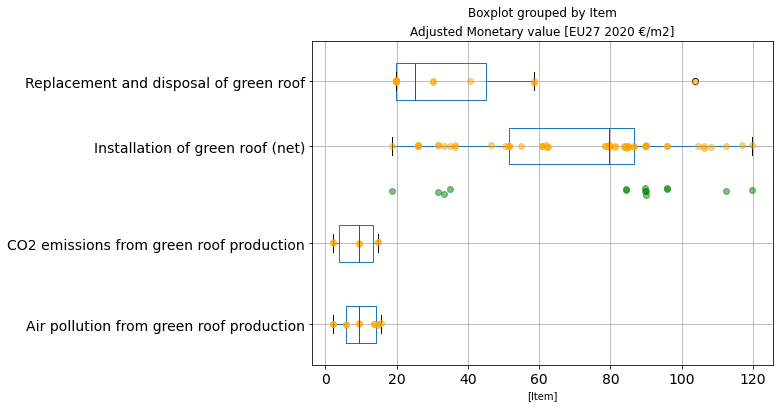

In [33]:
# plot all one-off costs (occurring one time only)

gl_costs_fig = global_costs[(global_costs["Item"]!="Installation of PV panels") &
                            (global_costs["Item"]!="Maintenance of green roof (net)")]

# gl_costs_fig = gl_costs_fig[(gl_costs_fig["Item"]=="Installation of green roof (net)") &
#                             (gl_costs_fig["Adjusted Monetary value [EU27 2020 €/m2]"]>7)]

loc_costs_fig = local_costs[(local_costs["Item"]!="Installation of PV panels") &
                            (local_costs["Item"]!="Maintenance of green roof (net)")]

# Add global analysis' boxplot
box_gl = gl_costs_fig.boxplot(column="Adjusted Monetary value [EU27 2020 €/m2]", by=["Item"], 
                      figsize=(8,6), 
                      fontsize=14, 
                      showfliers=True,
                      rot=0,
                      vert=False,
                      positions = [1,2,3.2,4],
                      return_type= "both",
                      color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))

# Add global analysis' datapoints
for n,item in enumerate( np.sort(gl_costs_fig["Item"].unique()) ):
    x = gl_costs_fig["Adjusted Monetary value [EU27 2020 €/m2]"][gl_costs_fig["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    if n == 2: #in the case of the "installation of green roofs (global)" increase the height
        n = 2.2
    
    y = np.random.normal(n+1, 0.01, size=len(x))
    plt.plot(x, y, 'orange', marker="o", linestyle="None", alpha=0.5)
    

# Add local analysis' boxplot and datapoints
for n,item in enumerate( np.sort(loc_costs_fig["Item"].unique()) ):  #There is only the installation of green roof item
    x = loc_costs_fig["Adjusted Monetary value [EU27 2020 €/m2]"][loc_costs_fig["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(2.65, 0.02, size=len(x))
    
    plt.plot(x, y, 'green', marker="o", linestyle="None", alpha=0.5)
    box_loc = plt.boxplot(x, positions = [2.65], vert=False, manage_xticks=False, patch_artist=True,
                widths=0.42,
                boxprops=dict(facecolor="None", color='#1f77b4'),
                capprops=dict(color="black"),
                whiskerprops=dict(color='#1f77b4'),
                flierprops=dict(color="white", markeredgecolor="black"),
                medianprops=dict(color="g"))
    
plt.yticks([1, 2, 2.65, 3.2, 4], ['Air pollution from green roof production (global)',
                                 'CO2 emission from green roof production (global)',
                                 'Installation of green roof (local)',
                                 'Installation of green roof (global)',
                                 'Replacement and disposal of green roof (global)'])
plt.xlabel('Monetary value [EU27 2020 €/m2]', fontsize=14, labelpad=15)
plt.title('', fontsize=15)
plt.ylim(0.5,4.5);

plt.savefig("Figures/One-off costs",dpi=300, bbox_inches = "tight")

# Whiskers' values
print("global boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box_gl[0].lines["whiskers"]])
print("local boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box_loc["whiskers"]])

global boxplots' whiskers:  [array([0., 0.]), array([ 9.62507652, 15.68987092]), array([0., 0.]), array([0., 0.]), array([50.54960327, 18.60599023]), array([ 86.06022907, 116.81589831]), array([19.77936574, 19.76692589]), array([45.14949014, 58.65354226])]
local boxplots' whiskers:  [array([43.51601323, 18.60599023]), array([76.82527269, 97.13581957])]


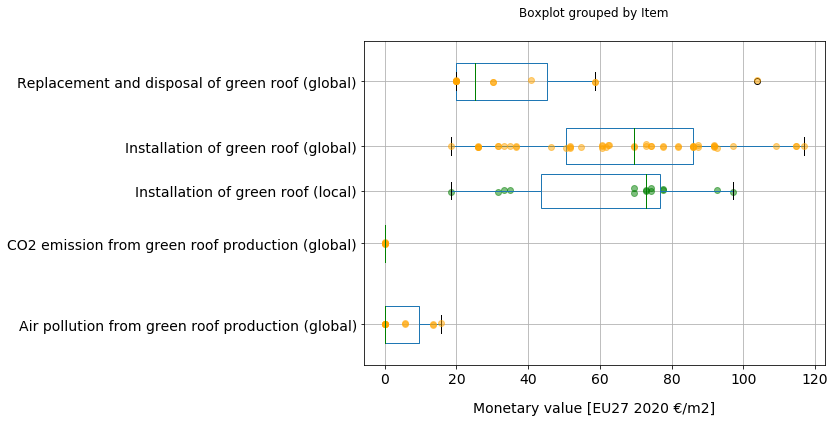

In [10]:
# plot all one-off costs (occurring one time only)

gl_costs_fig = global_costs[(global_costs["Item"]!="Installation of PV panels") &
                            (global_costs["Item"]!="Maintenance of green roof (net)")].drop([332,333,334,335,336], axis=0)

# gl_costs_fig = gl_costs_fig[(gl_costs_fig["Item"]=="Installation of green roof (net)") &
#                             (gl_costs_fig["Adjusted Monetary value [EU27 2020 €/m2]"]>7)]

loc_costs_fig = local_costs[(local_costs["Item"]!="Installation of PV panels") &
                            (local_costs["Item"]!="Maintenance of green roof (net)")]

# Add global analysis' boxplot
box_gl = gl_costs_fig.boxplot(column="Adjusted Monetary value [EU27 2020 €/m2]", by=["Item"], 
                      figsize=(8,6), 
                      fontsize=14, 
                      showfliers=True,
                      rot=0,
                      vert=False,
                      positions = [1,2,3.2,4],
                      return_type= "both",
                      color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))

# Add global analysis' datapoints
for n,item in enumerate( np.sort(gl_costs_fig["Item"].unique()) ):
    x = gl_costs_fig["Adjusted Monetary value [EU27 2020 €/m2]"][gl_costs_fig["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    if n == 2: #in the case of the "installation of green roofs (global)" increase the height
        n = 2.2
    
    y = np.random.normal(n+1, 0.01, size=len(x))
    plt.plot(x, y, 'orange', marker="o", linestyle="None", alpha=0.5)
    

# Add local analysis' boxplot and datapoints
for n,item in enumerate( np.sort(loc_costs_fig["Item"].unique()) ):  #There is only the installation of green roof item
    x = loc_costs_fig["Adjusted Monetary value [EU27 2020 €/m2]"][loc_costs_fig["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(2.65, 0.02, size=len(x))
    
    plt.plot(x, y, 'green', marker="o", linestyle="None", alpha=0.5)
    box_loc = plt.boxplot(x, positions = [2.65], vert=False, manage_xticks=False, patch_artist=True,
                widths=0.42,
                boxprops=dict(facecolor="None", color='#1f77b4'),
                capprops=dict(color="black"),
                whiskerprops=dict(color='#1f77b4'),
                flierprops=dict(color="white", markeredgecolor="black"),
                medianprops=dict(color="g"))
    
plt.yticks([1, 2, 2.65, 3.2, 4], ['Air pollution from green roof production (global)',
                                 'CO2 emission from green roof production (global)',
                                 'Installation of green roof (local)',
                                 'Installation of green roof (global)',
                                 'Replacement and disposal of green roof (global)'])
plt.xlabel('Monetary value [EU27 2020 €/m2]', fontsize=14, labelpad=15)
plt.title('', fontsize=15)
plt.ylim(0.5,4.5);

plt.savefig("Figures/One-off costs",dpi=300, bbox_inches = "tight")

# Whiskers' values
print("global boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box_gl[0].lines["whiskers"]])
print("local boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box_loc["whiskers"]])

[array([0.28680797, 0.03250996]),
 array([0.87875407, 1.08536447]),
 array([ 0.22850602, -0.89364729]),
 array([2.31617673, 4.02823162])]

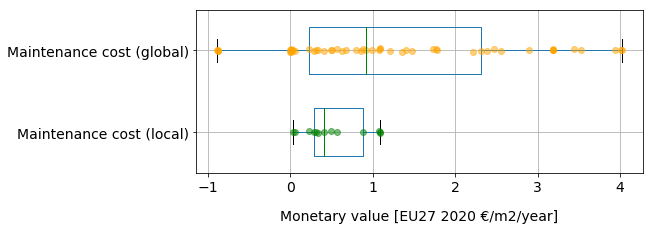

In [11]:
# plot maintenance cost (which is a yearly cost)

gl_maintenance = global_costs[global_costs["Item"]=="Maintenance of green roof (net)"]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_maintenance = local_costs[local_costs["Item"]=="Maintenance of green roof (net)"]["Adjusted Monetary value [EU27 2020 €/m2]"]

maintenance_df = pd.DataFrame({'Maintenance cost (local)': loc_maintenance, 'Maintenance cost (global)': gl_maintenance})

_, box = maintenance_df.boxplot(figsize=(8,3), 
                               fontsize=14, 
                               showfliers=True,
                               rot=0,
                               vert=False,
                               widths = 0.58,
                               return_type = "both",
                               color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_maintenance))
y_local = np.random.normal(1, 0.01, size=len(loc_maintenance))

#plot the datapoints
plt.plot(gl_maintenance, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_maintenance, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

    
plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14, labelpad=15)
plt.title('', fontsize=15);

plt.savefig("Figures/Maintenance cost",dpi=300, bbox_inches = "tight")

# whiskers' values
[whiskers.get_xdata() for whiskers in box["whiskers"]]

# 3. Visualization of Benefits

## 3.1 Comparison between air quality enhancement, CO2 emission reduction, and CO2 uptake

global boxplots' whiskers:  [array([0.06879006, 0.        ]), array([0.49991928, 1.08465183]), array([ 0.01652151, -0.02805637]), array([0.24315519, 0.37512404]), array([0., 0.]), array([0.02455038, 0.03952631])]
local boxplots' whiskers:  [array([0.00298844, 0.00284792]), array([0.00326946, 0.00340997])]


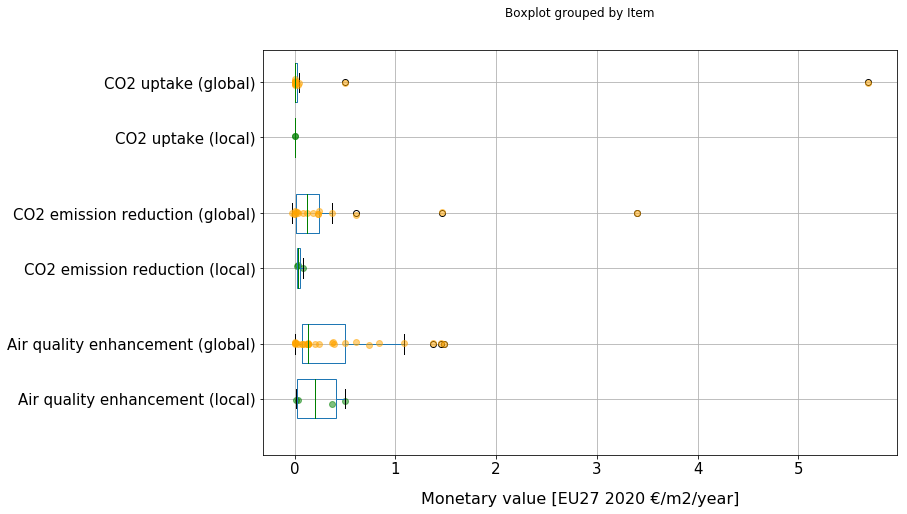

In [12]:
gl_air_quality = global_benefits[(global_benefits["Item"]=="Air quality enhancement") |
                                  (global_benefits["Item"]=="CO2 emission reduction") |
                                  (global_benefits["Item"]=="CO2 uptake") ]
loc_air_quality = local_benefits[(local_benefits["Item"]=="Air quality enhancement") |
                                  (local_benefits["Item"]=="CO2 emission reduction") |
                                  (local_benefits["Item"]=="CO2 uptake") ]



box_gl = gl_air_quality.boxplot(column="Adjusted Monetary value [EU27 2020 €/m2]", by=["Item"], 
                           figsize=(11,7.5), 
                           fontsize=15, 
                           showfliers=True,
                           vert=False,
                           widths = 0.3,
                           positions=[1.35, 2.35, 3.35],
                           return_type= "both",
                           color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))

# Add global analysis' datapoints
for n,item in enumerate( np.sort(gl_air_quality["Item"].unique()) ):
    x = gl_air_quality["Adjusted Monetary value [EU27 2020 €/m2]"][gl_air_quality["Item"]==item]
    
    # set the plot's position
    n += 0.35
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(n+1, 0.01, size=len(x))
    plt.plot(x, y, 'orange', marker="o", linestyle="None", alpha=0.5)

    
# Add local analysis boxplot and datapoints
for n,item in enumerate( np.sort(loc_air_quality["Item"].unique()) ):  #There is only the aesthetics increase
    x = loc_air_quality["Adjusted Monetary value [EU27 2020 €/m2]"][loc_air_quality["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(n+.93, 0.02, size=len(x))
    
    plt.plot(x, y, 'green', marker="o", linestyle="None", alpha=0.5)
    box_loc = plt.boxplot(x, positions = [n+.93], vert=False, manage_xticks=False, patch_artist=True,
                widths=0.3,
                boxprops=dict(facecolor="None", color='#1f77b4'),
                capprops=dict(color="black"),
                whiskerprops=dict(color='#1f77b4'),
                flierprops=dict(color="white", markeredgecolor="black"),
                medianprops=dict(color="g"))
    
    
plt.yticks([0.93, 1.35, 1.93, 2.35, 2.93, 3.35], 
           ["Air quality enhancement (local)",
           "Air quality enhancement (global)",
           "CO2 emission reduction (local)",
           "CO2 emission reduction (global)",
           "CO2 uptake (local)",
           "CO2 uptake (global)"],
           fontsize=15)        


plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=16, labelpad=15)
plt.ylim(0.5,3.6);
plt.title('')
plt.savefig("Figures/Air quality",dpi=300, bbox_inches = "tight")


# whiskers' values
print("global boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box_gl[0].lines["whiskers"]])
print("local boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box_loc["whiskers"]])

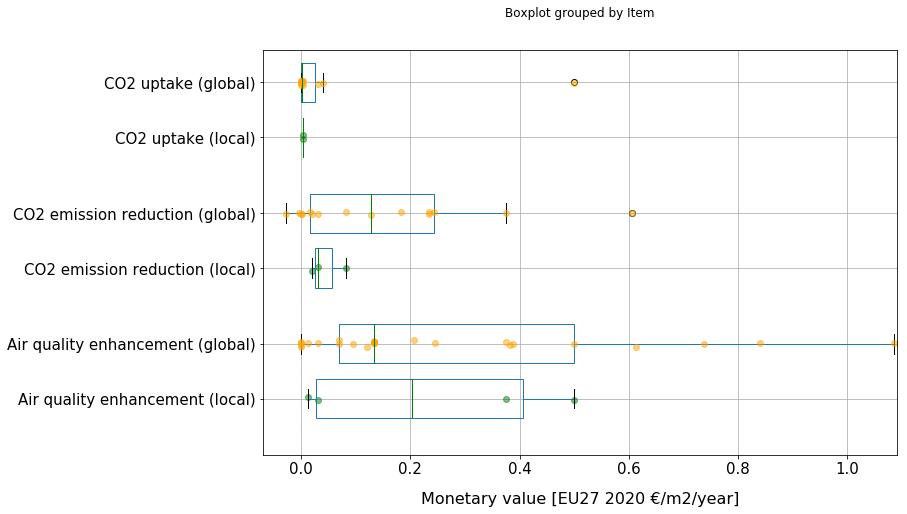

In [13]:
#Zoom of the previous figure

gl_air_quality = global_benefits[(global_benefits["Item"]=="Air quality enhancement") |
                                  (global_benefits["Item"]=="CO2 emission reduction") |
                                  (global_benefits["Item"]=="CO2 uptake") ]
loc_air_quality = local_benefits[(local_benefits["Item"]=="Air quality enhancement") |
                                  (local_benefits["Item"]=="CO2 emission reduction") |
                                  (local_benefits["Item"]=="CO2 uptake") ]



gl_air_quality.boxplot(column="Adjusted Monetary value [EU27 2020 €/m2]", by=["Item"], 
                           figsize=(11,7.5), 
                           fontsize=15, 
                           showfliers=True,
                           vert=False,
                           widths = 0.3,
                           positions=[1.35, 2.35, 3.35],
                           color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))

# Add global analysis' datapoints
for n,item in enumerate( np.sort(gl_air_quality["Item"].unique()) ):
    x = gl_air_quality["Adjusted Monetary value [EU27 2020 €/m2]"][gl_air_quality["Item"]==item]
    
    # set the plot's position
    n += 0.35
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(n+1, 0.01, size=len(x))
    plt.plot(x, y, 'orange', marker="o", linestyle="None", alpha=0.5)

    
# Add local analysis boxplot and datapoints
for n,item in enumerate( np.sort(loc_air_quality["Item"].unique()) ): 
    x = loc_air_quality["Adjusted Monetary value [EU27 2020 €/m2]"][loc_air_quality["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(n+.93, 0.02, size=len(x))
    
    plt.plot(x, y, 'green', marker="o", linestyle="None", alpha=0.5)
    plt.boxplot(x, positions = [n+.93], vert=False, manage_xticks=False, patch_artist=True,
                widths=0.3,
                boxprops=dict(facecolor="None", color='#1f77b4'),
                capprops=dict(color="black"),
                whiskerprops=dict(color='#1f77b4'),
                flierprops=dict(color="white", markeredgecolor="black"),
                medianprops=dict(color="g"))
    
    
plt.yticks([0.93, 1.35, 1.93, 2.35, 2.93, 3.35], 
           ["Air quality enhancement (local)",
           "Air quality enhancement (global)",
           "CO2 emission reduction (local)",
           "CO2 emission reduction (global)",
           "CO2 uptake (local)",
           "CO2 uptake (global)"],
           fontsize=15)        


plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=16, labelpad=15)
plt.title('')
plt.xlim(-.07,1.09);
plt.ylim(0.5,3.6);
plt.savefig("Figures/Air quality - zoom",dpi=300, bbox_inches = "tight")


## 3.2 Sound insulation

boxplots' whiskers:  [array([0.28864993, 0.27795919]), array([0.38862264, 0.38862264]), array([1.33620382, 0.27795919]), array([4.91117082, 4.91117082])]


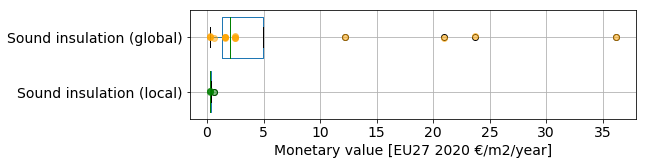

In [14]:
gl_sound = global_benefits[(global_benefits["Item"]=="Sound insulation")]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_sound = local_benefits[local_benefits["Item"]=="Sound insulation"]["Adjusted Monetary value [EU27 2020 €/m2]"]

sound_df = pd.DataFrame({'Sound insulation (local)': loc_sound, 'Sound insulation (global)': gl_sound})

_, box = sound_df.boxplot(figsize=(8,2), 
                 fontsize=14, 
                 showfliers=True,
                 rot=0,
                 vert=False,
                 widths = 0.75,
                 return_type="both",
                 color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_sound))
y_local = np.random.normal(1, 0.01, size=len(loc_sound))

#plot the datapoints
plt.plot(gl_sound, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_sound, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14)
plt.title('', fontsize=15)
plt.savefig("Figures/Sound",dpi=300, bbox_inches = "tight")

print("boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box["whiskers"]])

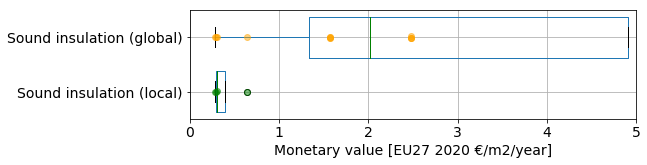

In [15]:
gl_sound = global_benefits[(global_benefits["Item"]=="Sound insulation")]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_sound = local_benefits[local_benefits["Item"]=="Sound insulation"]["Adjusted Monetary value [EU27 2020 €/m2]"]

sound_df = pd.DataFrame({'Sound insulation (local)': loc_sound, 'Sound insulation (global)': gl_sound})

sound_df.boxplot(figsize=(8,2), 
                 fontsize=14, 
                 showfliers=True,
                 rot=0,
                 vert=False,
                 widths = 0.75,
                 color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_sound))
y_local = np.random.normal(1, 0.01, size=len(loc_sound))

#plot the datapoints
plt.plot(gl_sound, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_sound, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14)
plt.title('', fontsize=15)
plt.xlim(0,5)

plt.savefig("Figures/Sound - zoom",dpi=300, bbox_inches = "tight")

boxplots' whiskers:  [array([0.28864993, 0.27795919]), array([0.38862264, 0.38862264]), array([0.55293225, 0.27795919]), array([2.47646367, 2.47646367])]


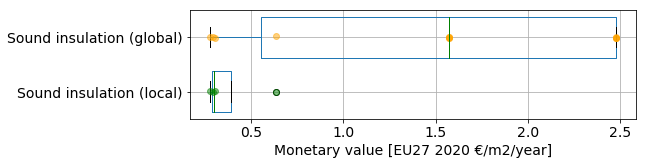

In [16]:
# Exclude case-studies' results that applied hedonic pricing to all floors instead of the highest (Almeida et al.) and 
# non least-cost options using the replacement cost method (Madyìhdiyar et al.). There are the monetary values higher than 10 €/m2 as
# it can be seen in the csv file.

gl_sound = global_benefits[(global_benefits["Item"]=="Sound insulation") &
               (global_benefits["Adjusted Monetary value [EU27 2020 €/m2]"] < 10)]["Adjusted Monetary value [EU27 2020 €/m2]"] 

loc_sound = local_benefits[local_benefits["Item"]=="Sound insulation"]["Adjusted Monetary value [EU27 2020 €/m2]"]

sound_df = pd.DataFrame({'Sound insulation (local)': loc_sound, 'Sound insulation (global)': gl_sound})

_, box = sound_df.boxplot(figsize=(8,2), 
                 fontsize=14, 
                 showfliers=True,
                 rot=0,
                 vert=False,
                 widths = 0.75,
                 return_type="both",
                 color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_sound))
y_local = np.random.normal(1, 0.01, size=len(loc_sound))

#plot the datapoints
plt.plot(gl_sound, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_sound, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14)
plt.title('', fontsize=15)
plt.savefig("Figures/Sound - correction",dpi=300, bbox_inches = "tight")

print("boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box["whiskers"]])

## 3.3 Aesthetics increase

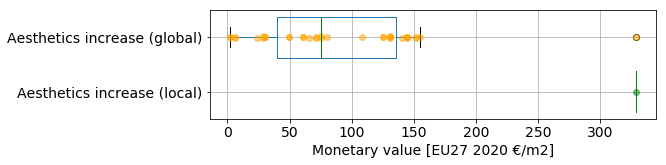

In [33]:
# Plot the Aesthetics increase benefit separately, since it has a different unit of measure

gl_aesthetics = global_benefits[(global_benefits["Item"]=="Aesthetics increase")]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_aesthetics = local_benefits[local_benefits["Item"]=="Aesthetics increase"]["Adjusted Monetary value [EU27 2020 €/m2]"]

aesthetics_df = pd.DataFrame({'Aesthetics increase (local)': loc_aesthetics, 'Aesthetics increase (global)': gl_aesthetics})

f = aesthetics_df.boxplot(figsize=(8,2), 
                          fontsize=14, 
                          showfliers=True,
                          rot=0,
                          vert=False,
                          widths = 0.75,
                          color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))

# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_aesthetics))
y_local = np.random.normal(1, 0.01, size=len(loc_aesthetics))

#plot the datapoints
plt.plot(gl_aesthetics, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_aesthetics, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

plt.xlabel('Monetary value [EU27 2020 €/m2]', fontsize=14)
plt.title('', fontsize=15)

plt.savefig("Figures/Aesthetics",dpi=300, bbox_inches = "tight")

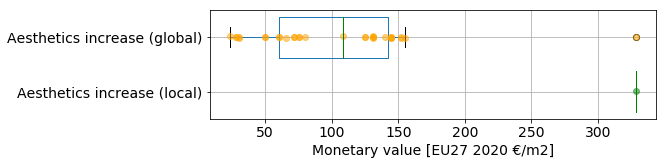

In [29]:
# Plot the Aesthetics increase without Bianchini and Hewage's results

gl_aesthetics = global_benefits[(global_benefits["Item"]=="Aesthetics increase") & 
                (global_benefits["Adjusted Monetary value [EU27 2020 €/m2]"]>7)]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_aesthetics = local_benefits[local_benefits["Item"]=="Aesthetics increase"]["Adjusted Monetary value [EU27 2020 €/m2]"]

aesthetics_df = pd.DataFrame({'Aesthetics increase (local)': loc_aesthetics, 'Aesthetics increase (global)': gl_aesthetics})

f = aesthetics_df.boxplot(figsize=(8,2), 
                          fontsize=14, 
                          showfliers=True,
                          rot=0,
                          vert=False,
                          widths = 0.75,
                          color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))

# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_aesthetics))
y_local = np.random.normal(1, 0.01, size=len(loc_aesthetics))

#plot the datapoints
plt.plot(gl_aesthetics, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_aesthetics, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

plt.xlabel('Monetary value [EU27 2020 €/m2]', fontsize=14)
plt.title('', fontsize=15)

plt.savefig("Figures/Aesthetics - correction",dpi=300, bbox_inches = "tight")

## 3.4 Stormwater management

[array([0.32365048, 0.09672573]),
 array([0.89378491, 1.46894293]),
 array([0.02786823, 0.0022549 ]),
 array([0.89196303, 1.46894293])]

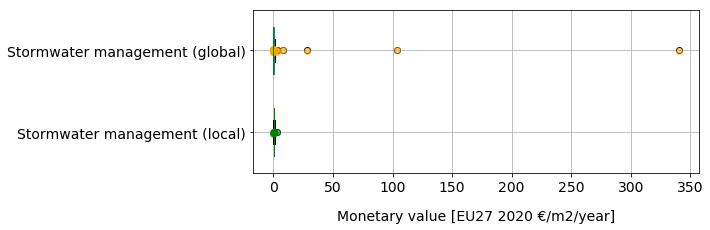

In [19]:
gl_stormwater = global_benefits[(global_benefits["Item"]=="Stormwater management")]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_stormwater = local_benefits[(local_benefits["Item"]=="Stormwater management")]["Adjusted Monetary value [EU27 2020 €/m2]"]

stormwater_df = pd.DataFrame({'Stormwater management (local)': loc_stormwater, 'Stormwater management (global)': gl_stormwater})

_, box = stormwater_df.boxplot(figsize=(8,3), 
                               fontsize=14, 
                               showfliers=True,
                               rot=0,
                               vert=False,
                               widths = 0.58,
                               return_type="both",
                               color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_stormwater))
y_local = np.random.normal(1, 0.01, size=len(loc_stormwater))

#plot the datapoints
plt.plot(gl_stormwater, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_stormwater, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

    
plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14, labelpad=15)
plt.title('', fontsize=15);

plt.savefig("Figures/Stormwater",dpi=300, bbox_inches = "tight")

# whiskers' values (the first numbers are the local boxplot's values)
[whiskers.get_xdata() for whiskers in box["whiskers"]]

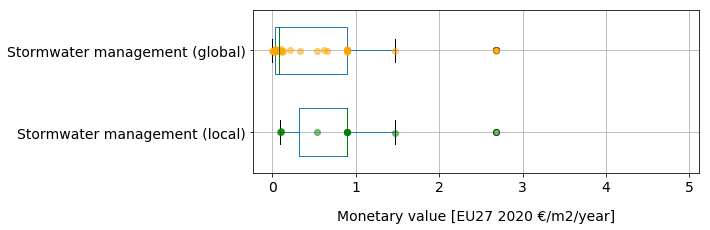

In [20]:
gl_stormwater = global_benefits[(global_benefits["Item"]=="Stormwater management")]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_stormwater = local_benefits[(local_benefits["Item"]=="Stormwater management")]["Adjusted Monetary value [EU27 2020 €/m2]"]

stormwater_df = pd.DataFrame({'Stormwater management (local)': loc_stormwater, 'Stormwater management (global)': gl_stormwater})

box = stormwater_df.boxplot(figsize=(8,3), 
                               fontsize=14, 
                               showfliers=True,
                               rot=0,
                               vert=False,
                               widths = 0.58,
                               color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_stormwater))
y_local = np.random.normal(1, 0.01, size=len(loc_stormwater))

#plot the datapoints
plt.plot(gl_stormwater, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_stormwater, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

plt.xlim(-.23,5.12)
plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14, labelpad=15)
plt.title('', fontsize=15);

plt.savefig("Figures/Stormwater - zoom",dpi=300, bbox_inches = "tight")

## 3.6 Energy consumption reduction

[array([0.28892377, 0.07898974]),
 array([0.46129663, 0.52114451]),
 array([ 0.28892377, -0.38447616]),
 array([1.7872481, 3.8655441])]

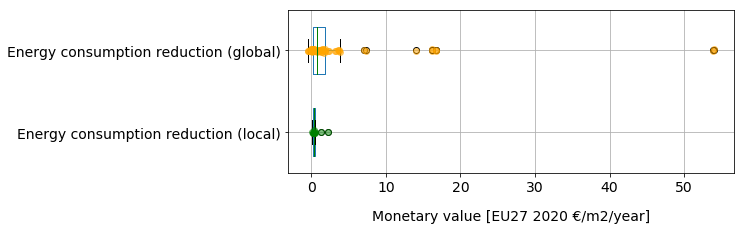

In [21]:
gl_energy_red = global_benefits[(global_benefits["Item"]=="Energy consumption reduction (heating and cooling)")]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_energy_red = local_benefits[(local_benefits["Item"]=="Energy consumption reduction (heating and cooling)")]["Adjusted Monetary value [EU27 2020 €/m2]"]

energy_red_df = pd.DataFrame({'Energy consumption reduction (local)': loc_energy_red, 'Energy consumption reduction (global)': gl_energy_red})

_, box = energy_red_df.boxplot(figsize=(8,3), 
                               fontsize=14, 
                               showfliers=True,
                               rot=0,
                               vert=False,
                               widths = 0.58,
                               return_type="both",
                               color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_energy_red))
y_local = np.random.normal(1, 0.01, size=len(loc_energy_red))

#plot the datapoints
plt.plot(gl_energy_red, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_energy_red, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

    
plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14, labelpad=15)
plt.title('', fontsize=15);

plt.savefig("Figures/Energy consumption reduction",dpi=300, bbox_inches = "tight")

# whiskers' values (the first numbers are the local boxplot's values)
[whiskers.get_xdata() for whiskers in box["whiskers"]]

[array([0.28892377, 0.07898974]),
 array([0.46129663, 0.52114451]),
 array([ 0.28892377, -0.38447616]),
 array([1.7872481, 3.8655441])]

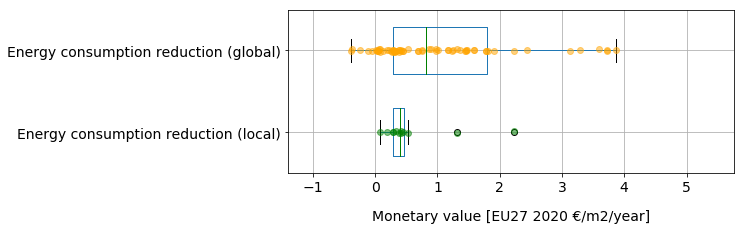

In [22]:
# Zoom of the previous figure

gl_energy_red = global_benefits[(global_benefits["Item"]=="Energy consumption reduction (heating and cooling)")]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_energy_red = local_benefits[(local_benefits["Item"]=="Energy consumption reduction (heating and cooling)")]["Adjusted Monetary value [EU27 2020 €/m2]"]

energy_red_df = pd.DataFrame({'Energy consumption reduction (local)': loc_energy_red, 'Energy consumption reduction (global)': gl_energy_red})

_, box = energy_red_df.boxplot(figsize=(8,3), 
                               fontsize=14, 
                               showfliers=True,
                               rot=0,
                               vert=False,
                               widths = 0.58,
                               return_type="both",
                               color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_energy_red))
y_local = np.random.normal(1, 0.01, size=len(loc_energy_red))

#plot the datapoints
plt.plot(gl_energy_red, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_energy_red, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

plt.xlim(-1.4,5.77)
plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14, labelpad=15)
plt.title('', fontsize=15);

plt.savefig("Figures/Energy consumption reduction - zoom",dpi=300, bbox_inches = "tight")

# whiskers' values (the first numbers are the local boxplot's values)
[whiskers.get_xdata() for whiskers in box["whiskers"]]

[array([0.28892377, 0.07898974]),
 array([0.46129663, 0.52114451]),
 array([ 0.28187111, -0.38447616]),
 array([1.72601856, 3.8655441 ])]

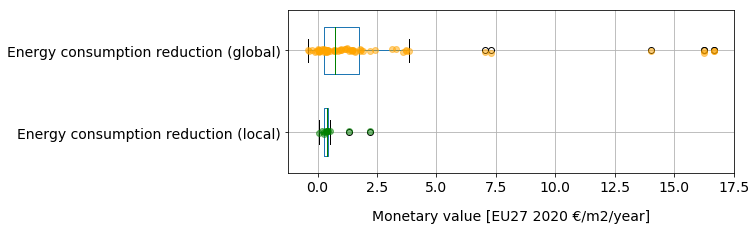

In [23]:
# Exclude values by William et al.

gl_energy_red = global_benefits[(global_benefits["Item"]=="Energy consumption reduction (heating and cooling)") &
                                (global_benefits["Adjusted Monetary value [EU27 2020 €/m2]"] < 50)]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_energy_red = local_benefits[(local_benefits["Item"]=="Energy consumption reduction (heating and cooling)")]["Adjusted Monetary value [EU27 2020 €/m2]"]

energy_red_df = pd.DataFrame({'Energy consumption reduction (local)': loc_energy_red, 'Energy consumption reduction (global)': gl_energy_red})

_, box = energy_red_df.boxplot(figsize=(8,3), 
                               fontsize=14, 
                               showfliers=True,
                               rot=0,
                               vert=False,
                               widths = 0.58,
                               return_type="both",
                               color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_energy_red))
y_local = np.random.normal(1, 0.01, size=len(loc_energy_red))

#plot the datapoints
plt.plot(gl_energy_red, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_energy_red, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14, labelpad=15)
plt.title('', fontsize=15);

plt.savefig("Figures/Energy consumption reduction - correction",dpi=300, bbox_inches = "tight")

# whiskers' values (the first numbers are the local boxplot's values)
[whiskers.get_xdata() for whiskers in box["whiskers"]]

## 3.5 Other benefits

global boxplots' whiskers:  [array([9.91527617, 2.79789135]), array([15.32994777, 18.84615094]), array([0.98865729, 0.        ]), array([3.31562514, 5.47801262]), array([0., 0.]), array([2.54408569, 3.26499858])]
local boxplots' whiskers:  [array([0., 0.]), array([0., 0.])]


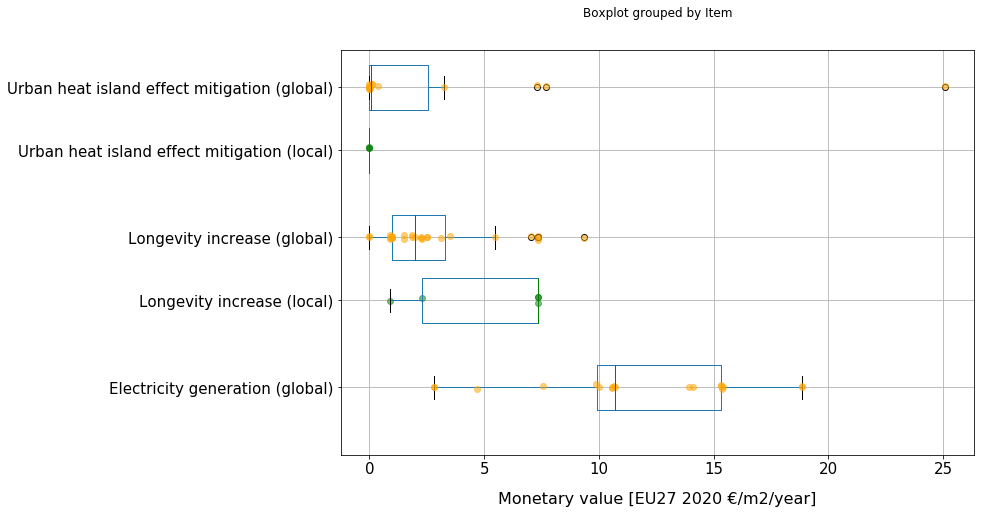

In [24]:
gl_benefits_overview = global_benefits[(global_benefits["Item"]=="Urban heat island effect mitigation") |
                                       (global_benefits["Item"]=="Longevity increase") |
                                       (global_benefits["Item"]=="Electricity generation")].drop([2,3,4,38,44,50,666,665,664,284,285], axis=0)
                                       
loc_benefits_overview = local_benefits[(local_benefits["Item"]=="Urban heat island effect mitigation") |
                                       (local_benefits["Item"]=="Longevity increase") |
                                       (local_benefits["Item"]=="Electricity generation")]



box_gl = gl_benefits_overview.boxplot(column="Adjusted Monetary value [EU27 2020 €/m2]", by=["Item"], 
                           figsize=(11,7.5), 
                           fontsize=15, 
                           showfliers=True,
                           vert=False,
                           widths = 0.3,
                           positions=[1.35, 2.35, 3.35],
                           return_type= "both",
                           color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))

# Add global analysis' datapoints
for n,item in enumerate( np.sort(gl_benefits_overview["Item"].unique()) ):
    x = gl_benefits_overview["Adjusted Monetary value [EU27 2020 €/m2]"][gl_benefits_overview["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(n+1.35, 0.01, size=len(x))
    plt.plot(x, y, 'orange', marker="o", linestyle="None", alpha=0.5)

    
# Add local analysis boxplot and datapoints
for m,item in enumerate( np.sort(loc_benefits_overview["Item"].unique()) ):
    x = loc_benefits_overview["Adjusted Monetary value [EU27 2020 €/m2]"][loc_benefits_overview["Item"]==item]
    
    m+= 1
    # Add some random "jitter" to the y-axis
    y = np.random.normal(m+.93, 0.02, size=len(x))
    
    plt.plot(x, y, 'green', marker="o", linestyle="None", alpha=0.5)
    box_loc = plt.boxplot(x, positions = [m+.93], vert=False, manage_xticks=False, patch_artist=True,
                widths=0.3,
                boxprops=dict(facecolor="None", color='#1f77b4'),
                capprops=dict(color="black"),
                whiskerprops=dict(color='#1f77b4'),
                flierprops=dict(color="white", markeredgecolor="black"),
                medianprops=dict(color="g"))
    
    
plt.yticks([1.35, 1.93, 2.35, 2.93, 3.35], 
           ["Electricity generation (global)",
           "Longevity increase (local)",
           "Longevity increase (global)",
           "Urban heat island effect mitigation (local)",
           "Urban heat island effect mitigation (global)"],
           fontsize=15)        


plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=16, labelpad=15)
plt.ylim(0.9,3.6);
plt.title('')
plt.savefig("Figures/Other benefits 1",dpi=300, bbox_inches = "tight")


# whiskers' values
print("global boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box_gl[0].lines["whiskers"]])
print("local boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box_loc["whiskers"]])

global boxplots' whiskers:  [array([0.00346801, 0.        ]), array([0.67175204, 0.67175204]), array([0.03109963, 0.        ]), array([0.09951882, 0.11195867]), array([0.00124399, 0.00124399]), array([0.14723783, 0.32377664])]
local boxplots' whiskers:  [array([0.30086792, 0.29323168]), array([0.3161404 , 0.32377664])]


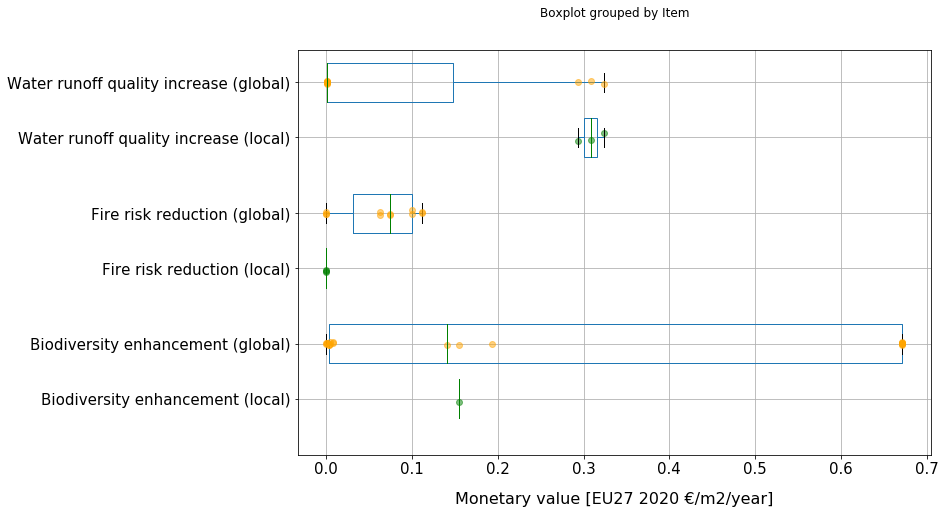

In [25]:
#Overview of distributions of the yearly benefits

gl_benefits_overview2 = global_benefits[(global_benefits["Item"]=="Water runoff quality increase") | 
                                       (global_benefits["Item"]=="Biodiversity enhancement") |
                                       (global_benefits["Item"]=="Fire risk reduction")]
                                       
loc_benefits_overview2 = local_benefits[(local_benefits["Item"]=="Water runoff quality increase") | 
                                       (local_benefits["Item"]=="Biodiversity enhancement") |
                                       (local_benefits["Item"]=="Fire risk reduction")]



box_gl = gl_benefits_overview2.boxplot(column="Adjusted Monetary value [EU27 2020 €/m2]", by=["Item"], 
                           figsize=(11,7.5), 
                           fontsize=15, 
                           showfliers=True,
                           vert=False,
                           widths = 0.3,
                           positions=[1.35, 2.35, 3.35],
                           return_type= "both",
                           color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))

# Add global analysis' datapoints
for n,item in enumerate( np.sort(gl_benefits_overview2["Item"].unique()) ):
    x = gl_benefits_overview2["Adjusted Monetary value [EU27 2020 €/m2]"][gl_benefits_overview2["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(n+1.35, 0.01, size=len(x))
    plt.plot(x, y, 'orange', marker="o", linestyle="None", alpha=0.5)

    
# Add local analysis boxplot and datapoints
for m,item in enumerate( np.sort(loc_benefits_overview2["Item"].unique()) ):
    x = loc_benefits_overview2["Adjusted Monetary value [EU27 2020 €/m2]"][loc_benefits_overview2["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(m+.93, 0.02, size=len(x))
    
    plt.plot(x, y, 'green', marker="o", linestyle="None", alpha=0.5)
    box_loc = plt.boxplot(x, positions = [m+.93], vert=False, manage_xticks=False, patch_artist=True,
                widths=0.3,
                boxprops=dict(facecolor="None", color='#1f77b4'),
                capprops=dict(color="black"),
                whiskerprops=dict(color='#1f77b4'),
                flierprops=dict(color="white", markeredgecolor="black"),
                medianprops=dict(color="g"))
    
    
plt.yticks([0.93, 1.35, 1.93, 2.35, 2.93, 3.35], 
           ["Biodiversity enhancement (local)",
           "Biodiversity enhancement (global)",
           "Fire risk reduction (local)",
           "Fire risk reduction (global)",
           "Water runoff quality increase (local)",
           "Water runoff quality increase (global)"],
           fontsize=15)        


plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=16, labelpad=15)
plt.ylim(0.5,3.6);
plt.title('')
plt.savefig("Figures/Other benefits 2",dpi=300, bbox_inches = "tight")


# whiskers' values
print("global boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box_gl[0].lines["whiskers"]])
print("local boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box_loc["whiskers"]])

## Additional code

In [ ]:
global_benefits[(global_benefits["Item"]=="Urban heat island effect mitigation")].drop([2,3,4,38,44,50,666,665,664,284,285], axis=0).boxplot(column="Adjusted Monetary value [EU27 2020 €/m2]", by=["Item"], 
                            figsize=(11,3), 
                            fontsize=14, 
                            showfliers=True,
                            rot = 0,
                            vert=False,
                            widths = 0.5,
                            color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))
# Add datapoints
gl_heat = global_benefits[(global_benefits["Item"]=="Urban heat island effect mitigation")].drop([2,3,4,38,44,50,666,665,664,284,285], axis=0)["Adjusted Monetary value [EU27 2020 €/m2]"]
# Add some random "jitter" to the y-axis
y_global = np.random.normal(1, 0.01, size=len(gl_heat))
# y_local = np.random.normal(1, 0.01, size=len(loc_stormwater))

#plot the datapoints
plt.plot(gl_heat, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
# plt.plot(loc_stormwater, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

# plt.xlim(-0.9, 1.9)


In [ ]:
#Overview of distributions of the yearly benefits

gl_benefits_overview = global_benefits[(global_benefits["Item"]=="Urban heat island effect mitigation") |
                                       (global_benefits["Item"]=="Water runoff quality increase") | 
                                       (global_benefits["Item"]=="Biodiversity enhancement") |
                                       (global_benefits["Item"]=="Energy consumption reduction (heating and cooling)") |
                                       (global_benefits["Item"]=="Longevity increase") |
                                       (global_benefits["Item"]=="Fire risk reduction") |
                                       (global_benefits["Item"]=="Electricity generation")]
                                       
loc_benefits_overview = local_benefits[(local_benefits["Item"]=="Urban heat island effect mitigation") |
                                       (local_benefits["Item"]=="Water runoff quality increase") | 
                                       (local_benefits["Item"]=="Biodiversity enhancement") |
                                       (local_benefits["Item"]=="Energy consumption reduction (heating and cooling)") |
                                       (local_benefits["Item"]=="Longevity increase") |
                                       (local_benefits["Item"]=="Fire risk reduction") |
                                       (local_benefits["Item"]=="Electricity generation")]

gl_boxplot_positions = range(1,8,1)
gl_benefits_overview.boxplot(column="Adjusted Monetary value [EU27 2020 €/m2]", by=["Item"], 
                            figsize=(11,14), 
                            fontsize=14, 
                            showfliers=True,
                            rot = 0,
                            vert=False,
                            widths = 0.5,
                            positions = gl_boxplot_positions,
                            color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))
                           
plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14, labelpad=15)
plt.title('', fontsize=15);



In [ ]:
#Overview of distributions of the one-time benefits

gl_aesthetics = global_benefits[(global_benefits["Item"]=="Local area's aesthetics increase") |
                                    (global_benefits["Item"]=="Aesthetics increase")]
loc_aesthetics = local_benefits[(local_benefits["Item"]=="Local area's aesthetics increase") |
                                    (local_benefits["Item"]=="Aesthetics increase")]

# Add global analysis' boxplots
gl_aesthetics.boxplot(column="Adjusted Monetary value [EU27 2020 €/m2]", by=["Item"], 
                            figsize=(8,5), 
                            fontsize=14, 
                            showfliers=True,
                            rot = 0,
                            vert=False,
                            widths = 0.5,
                            positions=[1.2, 2],
                            color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add global analysis' datapoints
for n,item in enumerate( np.sort(gl_aesthetics["Item"].unique()) ):
    x = gl_aesthetics["Adjusted Monetary value [EU27 2020 €/m2]"][gl_aesthetics["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    if n == 0: #in the case of the "Aesthetics increase (global)" increase the height
        n = 0.2
    
    y = np.random.normal(n+1, 0.01, size=len(x))
    plt.plot(x, y, 'orange', marker="o", linestyle="None", alpha=0.5)

    
    
# Add local analysis boxplot and datapoints

for n,item in enumerate( np.sort(loc_aesthetics["Item"].unique()) ):  #There is only the aesthetics increase
    x = loc_aesthetics["Adjusted Monetary value [EU27 2020 €/m2]"][loc_aesthetics["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(0.5, 0.02, size=len(x))
    
    plt.plot(x, y, 'green', marker="o", linestyle="None", alpha=0.5)
    plt.boxplot(x, positions = [0.5], vert=False, manage_xticks=False, patch_artist=True,
                widths=0.47,
                boxprops=dict(facecolor="None", color='#1f77b4'),
                capprops=dict(color="black"),
                whiskerprops=dict(color='#1f77b4'),
                flierprops=dict(color="white", markeredgecolor="black"),
                medianprops=dict(color="g"))
    
    
plt.yticks([0.5, 1.2, 2], ["Aesthetics increase (local)",
                           "Aesthetics increase (global)",
                           "Surrounding area's aesthetics increase (global)"])    
plt.xlabel('Monetary value [EU27 2020 €/m2]', fontsize=14, labelpad=15)
plt.title('', fontsize=15);
plt.ylim(-.1,2.5);

In [ ]:
# When outliers are excluded from the analysis the distribution of benefit values is provided by the following figure.
# The number of values for each item (i.e., cost or benefit) is provided in the summary_benefits table calculated at the top
# of this document

benefits_data_without_area_aesth = benefits_data[(benefits_data["Item"]!="Local area's aesthetics increase") & 
                                                 (benefits_data["Item"]!="Aesthetics increase")
                                                ]

benefits_data_without_area_aesth.boxplot(column="Adjusted Monetary value [EU27 2019 €/m2]", by=["Item"], 
                                         figsize=(11,6), 
                                         fontsize=14, 
                                         showfliers=False,
                                         rot = 90,
                                         color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))
                           
plt.ylabel('Adjusted Monetary value [EU27 2019 €/m2/year]', fontsize=14)
plt.title('', fontsize=15);

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6), sharey = False) # create 1x2 array of subplots
plt.title('', fontsize=15)
# plt.savefig("Figures/Air quality overlaps",dpi=300, bbox_inches = "tight")


air_quality_issues = cleaned_data[(cleaned_data["Item"]=="Air quality enhancement") |
                                  (cleaned_data["Item"]=="CO2 emission reduction") |
                                  (cleaned_data["Item"]=="CO2 uptake") ]
CO2_uptake = cleaned_data[cleaned_data["Item"]=="CO2 uptake"]


air_quality_issues.boxplot(column="Adjusted Monetary value [EU27 2019 €/m2]", by=["Item"], 
                           figsize=(15,6), 
                           fontsize=14, 
                           showfliers=True,
                           color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'),
                           ax = axes[0])
axes[0].set(ylabel= "Adjusted Monetary value [EU27 2019 €/m2/year]")
                           


CO2_uptake.boxplot(column="Adjusted Monetary value [EU27 2019 €/m2]", by=["Item"], 
                           figsize=(3,6), 
                           fontsize=14, 
                           showfliers=True,
                           color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'),
                           ax = axes[1])

## 4. Time horizon of CBAs

In [26]:
# Load global analysis data
raw_CBA_data = pd.read_csv("Data/CBA parameters.csv")
raw_CBA_data

,Private discount rate (min) [%],Private discount rate (max) [%],Social discount rate (min) [%],Social discount rate (max) [%],Non-specified type of iscount rate (min) [%],Non-specified type of discount rate (max) [%],Time horizon [years],Authors,Year,Author and year,Study,Notes,Local analysis,Unnamed: 13
0,4.00,4.00,4.00,4.00,NaN,NaN,40,Carter & Keeler,2008,Carter & Keeler (2008),Life-cycle cost-benefit analysis of extensive ...,commercial buildings: Although the whole area ...,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,20,Ascione et al.,2013,Ascione et al. (2013),Green roofs in European climates. Are effectiv...,€ values concerned with the UK were converted ...,x,yes
2,9.00,9.00,4.00,4.00,NaN,NaN,50,Claus & Rousseau,2012,Claus & Rousseau (2012),Public versus private incentives to invest in ...,Maintenance cost: includes water sampling cost...,x,NaN
3,8.00,15.00,NaN,NaN,NaN,NaN,50,Mahdiyar et al.,2016,Mahdiyar et al. (2016),Probabilistic private cost-benefit analysis fo...,$ values were converted to MYR currency with t...,NaN,yes
4,NaN,NaN,2.00,8.00,NaN,NaN,55,Bianchini & Hewage,2012,Bianchini & Hewage (2012),Probabilistic social cost-benefit analysis for...,NaN,x,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,40,Bianchini & Hewage,2012,Bianchini & Hewage (2012),Probabilistic social cost-benefit analysis for...,NaN,NaN,yes
6,3.00,3.00,NaN,NaN,NaN,NaN,25,McRae,2016,McRae (2016),Case study: A conservative approach to green r...,NaN,NaN,yes
7,NaN,NaN,NaN,NaN,5.0,5.0,40,Clark et al.,2008,Clark et al. (2008),Green roof valuation: a probabilisitc economic...,Extensive roof depth: 5-15 cm,NaN,yes
8,3.50,3.50,NaN,NaN,NaN,NaN,50,Perini & Rosasco,2016,Perini & Rosasco (2016),Is greening the building envelope economically...,NaN,NaN,yes
9,NaN,NaN,NaN,NaN,NaN,NaN,10,Gwak et al.,2017,Gwak et al. (2017),Optimal location selection for the installatio...,$ values were converted to KRW currency with t...,NaN,yes


In [27]:
# Select local analysis data
local_CBA_data = raw_CBA_data[raw_CBA_data["Local analysis"]=="x"]
local_CBA_data

,Private discount rate (min) [%],Private discount rate (max) [%],Social discount rate (min) [%],Social discount rate (max) [%],Non-specified type of iscount rate (min) [%],Non-specified type of discount rate (max) [%],Time horizon [years],Authors,Year,Author and year,Study,Notes,Local analysis,Unnamed: 13
1,NaN,NaN,NaN,NaN,NaN,NaN,20,Ascione et al.,2013,Ascione et al. (2013),Green roofs in European climates. Are effectiv...,€ values concerned with the UK were converted ...,x,yes
2,9.0,9.0,4.0,4.0,NaN,NaN,50,Claus & Rousseau,2012,Claus & Rousseau (2012),Public versus private incentives to invest in ...,Maintenance cost: includes water sampling cost...,x,NaN
4,NaN,NaN,2.0,8.0,NaN,NaN,55,Bianchini & Hewage,2012,Bianchini & Hewage (2012),Probabilistic social cost-benefit analysis for...,NaN,x,NaN
11,NaN,NaN,4.0,4.0,NaN,NaN,50,Machac et al.,2016,Machac et al. (2016),Green and Blue Infrastructure: An Opportunity ...,NaN,x,NaN
17,3.0,3.0,3.0,3.0,NaN,NaN,50,Johnson & Geisendorf,2019,Johnson & Geisendorf (2019),Are Neighborhood-level SUDS Worth it? An asses...,Degree days for cooling were considered to be ...,x,NaN


C:\Users\Timme\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


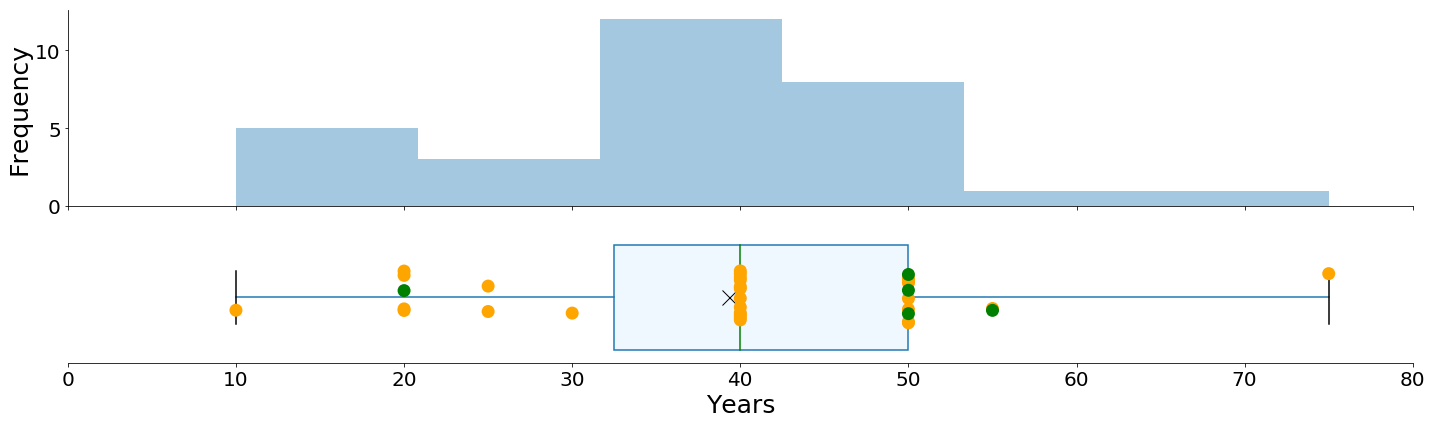

In [28]:
# Plot the distribution of CBAs' time_horizon 

# prepare data for global and local analyses' plots
global_data = raw_CBA_data[["Time horizon [years]"]]
local_data = raw_CBA_data[raw_CBA_data["Local analysis"]=="x"]["Time horizon [years]"]

# generate boxplot with distribution of values (strip plot) for the global and, in a different color, for the local 
# analysis, additionally plot the and histogram of values for the global analysis on top of it.
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, figsize=(20,6),
                                    gridspec_kw={"height_ratios": (0.60, 0.4)})

sns.distplot(global_data, ax=ax_hist, bins= 6, kde= False)
sns.stripplot(global_data, jitter=0.23, ax=ax_box, size=13, color="orange")
sns.stripplot(local_data, jitter=0.2, ax=ax_box, size=13, color="green")

props = {
    'boxprops':{'facecolor':'aliceblue', 'edgecolor':'#1f77b4'},
    'medianprops':{'color':'g'},
    'whiskerprops':{'color':'#1f77b4'},
    'capprops':{'color':'black'}}

sns.boxplot(global_data, ax=ax_box,
            showmeans = True,
            meanprops={"marker":"x","markerfacecolor":"black", "markeredgecolor":"black", "markersize":15},
           **props)


ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

ax_box.set_xlim(0,80)
ax_hist.set_xlim(0,80)
ax_box.set_xlabel("Years",fontsize=25)
ax_hist.set_ylabel("Frequency",fontsize=25)
ax_box.tick_params(axis='x', which='major', labelsize=20)
ax_hist.tick_params(axis='x', which='major', labelsize=20)
ax_hist.tick_params(axis='y', which='major', labelsize=20)
f.tight_layout()

# Save the plot
plt.savefig("Figures/CBA time horizons strip_plot",dpi=300, bbox_inches = "tight")

In [11]:
x_global = pd.DataFrame(raw_CBA_data["Time horizon [years]"])
x_global = pd.merge(x_global, pd.Series(np.zeros(len(x_global)), name="local_analysis"), left_index=True, right_index=True)
x_local = pd.DataFrame(raw_CBA_data[raw_CBA_data["Local analysis"]=="x"]["Time horizon [years]"])
x_local = pd.merge(x_local, pd.Series(np.ones(len(x_local)), name="local_analysis"), left_index=True, right_index=True)

x_df = x_global.append(x_local, ignore_index= True)
x_df

NameError: name 'raw_CBA_data' is not defined